In [1]:
import tensorflow as tf
import gudhi as gd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils
import scipy.spatial as spatial
import json
from rich import print
from random import choice, sample
from tqdm.notebook import tqdm
from rdkit import Chem
from rdkit.Chem import Descriptors
from gc import collect
from pickle import load
from sklearn.preprocessing import MinMaxScaler

with open("9701_cech_persistence_images_012_50x50.pickle", mode = "rb") as data:
    save_dict = load(data)
    train_molecules = save_dict["train_molecules"]
    train_data = save_dict["train_data"]
    
    test_molecules = save_dict["test_molecules"]
    test_data = save_dict["test_data"]
    
%matplotlib inline
del save_dict
collect()

4

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]
        )
    except RuntimeError as e:
        print(e)

In [3]:
print(train_data.shape, test_data.shape)

(7761, 9, 50, 50)
(1940, 9, 50, 50)

for ims in tqdm(train_data):
    for im in ims:
        max_px = im.max()
        assert not (max_px < 0.0)
        if max_px > 0.0:
            im *= 1/max_px
        
for ims in tqdm(test_data):
    for im in ims:
        max_px = im.max()
        assert not (max_px < 0.0)
        if max_px > 0.0:
            im *= 1/max_px

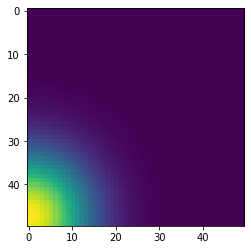

In [4]:
plt.imshow(train_data[10,3])

# Extract descriptors
(this can be done from rdkit or from the descriptor .csv)

In [5]:
df = pd.read_csv("data/Drugbank_some_descriptors.csv")
cntr = 0
for d in df:
    cntr += 1
print(cntr)

126

### Filter descriptors which are unavailable

In [6]:
descriptors = list()

# consider only descriptors which have few missing values and which are floating point
for d in df:
    if df[d].isna().sum() < 800 and df[d].dtype == np.float64:
        descriptors.append(d)

filter_descriptors = filter(lambda d : "OEselma Descriptors" not in d, descriptors)
descriptors = list(set(descriptors) - set(filter_descriptors))
num_descriptors = len(descriptors)
print(descriptors)

# select only smiles which have these descriptor values
train_smiles = set(train_molecules)
test_smiles = set(test_molecules)

for i,d in enumerate(descriptors):
    avail_rows = df[np.logical_not(df[d].isna())]
    train_smiles = set(avail_rows["SMILES"]).intersection(train_smiles)
    test_smiles = set(avail_rows["SMILES"]).intersection(test_smiles)

train_idxs = np.asarray(sorted([ train_molecules.index(t) for t in train_smiles ]))
test_idxs = np.asarray(sorted([ test_molecules.index(t) for t in test_smiles ]))

train_molecules = np.asarray(train_molecules)
train_molecules = train_molecules[train_idxs]
train_data = train_data[train_idxs]

test_molecules = np.asarray(test_molecules)
test_molecules = test_molecules[test_idxs]
test_data = test_data[test_idxs]

[
    'OEselma Descriptors;ring_count',
    'OEselma Descriptors;fluorine_count',
    'OEselma Descriptors;rigid_frag_count',
    'OEselma Descriptors;oxygen_count',
    'OEselma Descriptors;clorine_count',
    'OEselma Descriptors;hbd',
    'OEselma Descriptors;psa',
    'OEselma Descriptors;part_flex_chain',
    'OEselma Descriptors;carbon_count',
    'OEselma Descriptors;silicon_count',
    'OEselma Descriptors;sulphur_count',
    'OEselma Descriptors;bromine_count',
    'OEselma Descriptors;hbd_lipinski',
    'OEselma Descriptors;mw',
    'OEselma Descriptors;halogen_count',
    'OEselma Descriptors;phosphorous_count',
    'OEselma Descriptors;max_rigid_chain',
    'OEselma Descriptors;bond_count',
    'OEselma Descriptors;nonpolar_count',
    'OEselma Descriptors;hba_lipinski',
    'OEselma Descriptors;npsa',
    'OEselma Descriptors;ertl_tpsa',
    'OEselma Descriptors;polar_count',
    'OEselma Descriptors;aromatic_ring_count',
    'OEselma Descriptors;max_flex_chain_3',
    'OEselma Descriptors;nitrogen_count',
    'OEselma Descriptors;neg_ioniz',
    'OEselma Descriptors;atom_count',
    'OEselma Descriptors;iodine_count',
    'OEselma Descriptors;pos_ioniz',
    'OEselma Descriptors;rot_bond_count',
    'OEselma Descriptors;nonpolar_count_per_mw',
    'OEselma Descriptors;max_flex_chain_2',
    'OEselma Descriptors;tsa',
    'OEselma Descriptors;mol_volume_2d',
    'OEselma Descriptors;rigid_bond_count',
    'OEselma Descriptors;polar_count_per_mw',
    'OEselma Descriptors;max_flex_chain_1',
    'OEselma Descriptors;hba'
]

In [7]:
print(train_data.shape, test_data.shape)

(7543, 9, 50, 50)
(1888, 9, 50, 50)

### Build numpy arrays of descriptors

In [8]:
collect()
train_labels = np.empty((train_data.shape[0], num_descriptors))
test_labels = np.empty((test_data.shape[0], num_descriptors))
train_labels[:] = np.nan
test_labels[:] = np.nan

for i,mol in enumerate(tqdm(train_molecules)):
    data_row = df.loc[df['SMILES'] == mol, descriptors ]
    data_vec = [ r.to_list()[-1] for l,r in data_row.items() ]
    train_labels[i,:] = np.asarray(data_vec)

for i,mol in enumerate(tqdm(test_molecules)):
    data_row = df.loc[df['SMILES'] == mol, descriptors ]
    data_vec = [ r.to_list()[-1] for l,r in data_row.items() ]
    test_labels[i,:] = np.asarray(data_vec)

  0%|          | 0/7543 [00:00<?, ?it/s]

  0%|          | 0/1888 [00:00<?, ?it/s]

In [9]:
print(train_labels.shape, test_labels.shape)

(7543, 39)
(1888, 39)

In [10]:
print(not np.isnan(train_labels).any(), not np.isnan(test_labels).any())

True True

In [11]:
with np.printoptions(2, suppress = True):
    _idx = choice(list(range(train_labels.shape[0])))
    print(train_labels[_idx])

[  1.     0.     1.     1.     0.     1.    24.05   4.    14.     0.
   0.     0.     1.   221.3    0.     0.     5.    16.    12.     2.
 293.92  23.47   2.     1.     2.     1.     0.    16.     0.     1.
   5.     0.05   4.   318.   449.49   6.     0.01   4.     2.  ]

# Normalize Labels

In [12]:
train_scaler = MinMaxScaler(feature_range=(0, 1)).fit(train_labels)
train_labels = train_scaler.transform(train_labels)

test_scaler = MinMaxScaler(feature_range=(0, 1)).fit(test_labels)
test_labels = test_scaler.transform(test_labels)

In [13]:
with np.printoptions(2, suppress = True):
    print(train_scaler.inverse_transform(train_labels)[_idx])
    print(train_labels[_idx])

[  1.     0.     1.     1.     0.     1.    24.05   4.    14.     0.
   0.     0.     1.   221.3    0.     0.     5.    16.    12.     2.
 293.92  23.47   2.     1.     2.     1.     0.    16.     0.     1.
   5.     0.05   4.   318.   449.49   6.     0.01   4.     2.  ]

[0.09 0.   0.02 0.02 0.   0.02 0.02 0.09 0.12 0.   0.   0.   0.02 0.08
 0.   0.   0.17 0.09 0.45 0.03 0.15 0.02 0.03 0.1  0.06 0.03 0.   0.09
 0.   0.06 0.06 0.84 0.12 0.1  0.1  0.07 0.13 0.11 0.05]

# Setup CNN

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Normalization(
        input_shape = train_data.shape[1:],
    ),
    tf.keras.layers.Conv2D(
        filters = 32,
        kernel_size = 3, # sliding window
        data_format = "channels_first",
        activation = "relu",
    ),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(
        filters = 32,
        kernel_size = 5,
        activation = "relu"
    ),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_descriptors),
])

2022-01-13 18:37:51.744311: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-13 18:37:52.144012: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4096 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9, 50, 50)        101       
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 32, 48, 48)        2624      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 24, 48)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 20, 32)        38432     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 10, 32)        0         
 2D)                                                             
                                                        

In [16]:
model.compile(
    optimizer = "adam",#tf.keras.optimizers.Adam(learning_rate = .05),
    loss = "mean_absolute_error",
)

In [17]:
%%time
history = model.fit(
    train_data,
    train_labels,
    verbose = 1,
    epochs = 100,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2
)

2022-01-13 18:37:52.662301: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 543060000 exceeds 10% of free system memory.
2022-01-13 18:37:53.027598: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 543060000 exceeds 10% of free system memory.


Epoch 1/100


2022-01-13 18:37:53.990554: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301


189/189 [==============================] - ETA: 0s - loss: 0.1341

2022-01-13 18:37:55.718452: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 135810000 exceeds 10% of free system memory.
2022-01-13 18:37:55.812749: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 135810000 exceeds 10% of free system memory.


189/189 [==============================] - 3s 8ms/step - loss: 0.1341 - val_loss: 0.0488
Epoch 2/100
189/189 [==============================] - 1s 6ms/step - loss: 0.0469 - val_loss: 0.0452
Epoch 3/100
189/189 [==============================] - 1s 6ms/step - loss: 0.0454 - val_loss: 0.0445
Epoch 4/100
189/189 [==============================] - 1s 6ms/step - loss: 0.0446 - val_loss: 0.0444
Epoch 5/100
189/189 [==============================] - 1s 6ms/step - loss: 0.0440 - val_loss: 0.0442
Epoch 6/100
189/189 [==============================] - 1s 6ms/step - loss: 0.0437 - val_loss: 0.0440
Epoch 7/100
189/189 [==============================] - 1s 6ms/step - loss: 0.0433 - val_loss: 0.0435
Epoch 8/100
189/189 [==============================] - 1s 6ms/step - loss: 0.0432 - val_loss: 0.0434
Epoch 9/100
189/189 [==============================] - 1s 6ms/step - loss: 0.0433 - val_loss: 0.0431
Epoch 10/100
189/189 [==============================] - 1s 6ms/step - loss: 0.0430 - val_loss: 0.0433
E

189/189 [==============================] - 1s 6ms/step - loss: 0.0408 - val_loss: 0.0419
Epoch 82/100
189/189 [==============================] - 1s 6ms/step - loss: 0.0406 - val_loss: 0.0421
Epoch 83/100
189/189 [==============================] - 1s 6ms/step - loss: 0.0407 - val_loss: 0.0419
Epoch 84/100
189/189 [==============================] - 1s 6ms/step - loss: 0.0405 - val_loss: 0.0420
Epoch 85/100
189/189 [==============================] - 1s 6ms/step - loss: 0.0406 - val_loss: 0.0419
Epoch 86/100
189/189 [==============================] - 1s 6ms/step - loss: 0.0407 - val_loss: 0.0423
Epoch 87/100
189/189 [==============================] - 1s 6ms/step - loss: 0.0406 - val_loss: 0.0423
Epoch 88/100
189/189 [==============================] - 1s 6ms/step - loss: 0.0406 - val_loss: 0.0419
Epoch 89/100
189/189 [==============================] - 1s 6ms/step - loss: 0.0407 - val_loss: 0.0419
Epoch 90/100
189/189 [==============================] - 1s 6ms/step - loss: 0.0406 - val_loss: 

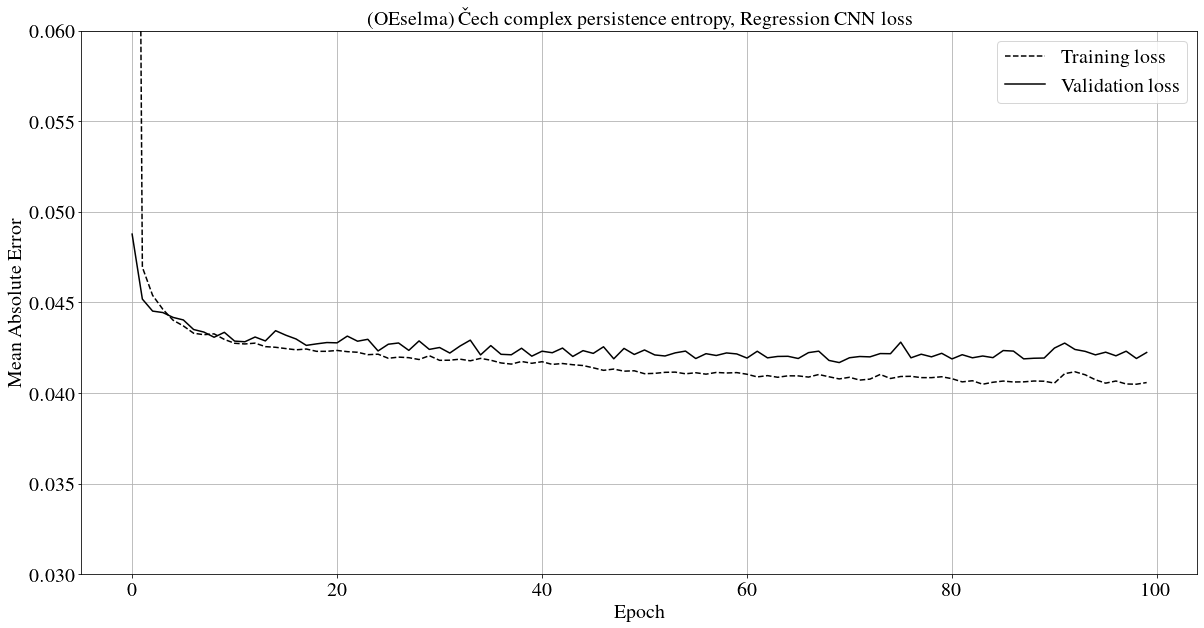

In [24]:
def plot_loss(history):
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot()
    p1 = ax.plot(history.history['loss'], "--", color = "black")
    p2 = ax.plot(history.history['val_loss'], color = "black")
    ax.set_ylim([.03, .06])
    ax.set_xlabel('Epoch', fontsize = 20)
    ax.set_ylabel('Mean Absolute Error', fontsize = 20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.legend(["Training loss", "Validation loss"], fontsize = 20)
    ax.grid(True)
    ax.set_title("(OEselma) Čech complex persistence entropy, Regression CNN loss", fontsize = 20)
    #ax.set_title("(All descriptors) Čech complex persistence entropy, Regression CNN loss", fontsize = 20)
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Times"
})
plot_loss(history)

In [19]:
predicted = model.predict(test_data).reshape((test_data.shape[0],num_descriptors))

2022-01-13 18:39:46.165451: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 169920000 exceeds 10% of free system memory.


In [20]:
test_labels = test_scaler.inverse_transform(test_labels)
predicted = test_scaler.inverse_transform(predicted)

In [21]:
out_dict = dict()
out_dict["Descriptor"] = list()
out_dict["_sigma"] = list()
out_dict["Average"] = list()
out_dict["Test Average"] = test_labels.mean(axis = 0)
out_dict["MAE"] = np.abs(test_labels - predicted).mean(axis = 0)

for i,d in enumerate(descriptors):
    out_dict["Descriptor"].append(d)
    out_dict["Average"].append(df[d].mean(skipna = True)) # population mean for this descriptor
    out_dict["_sigma"].append(df[d].std(skipna = True)) # population mean for this descriptor
    
out_dict["MAE/sigma"] = out_dict["MAE"]/out_dict["_sigma"]

pd.set_option("display.max_rows", None, "display.max_columns", None)
out_df = pd.DataFrame(data = out_dict)
print(out_dict["MAE"].sum()/len(descriptors)) # THIS IS WHAT tf.keras.losses.MeanAbsoluteError() DOES
out_df = out_df.sort_values("MAE/sigma")
print(out_dict["MAE/sigma"].mean())
out_df

18.75698100044504

0.5077136248006651

,Descriptor,_sigma,Average,Test Average,MAE,MAE/sigma
9,OEselma Descriptors;silicon_count,0.108439,0.004239,0.001059,0.001745,0.016093
28,OEselma Descriptors;iodine_count,0.287843,0.028450,0.025953,0.029030,0.100853
11,OEselma Descriptors;bromine_count,0.265308,0.034856,0.034428,0.036573,0.137850
15,OEselma Descriptors;phosphorous_count,0.474829,0.122751,0.115466,0.118135,0.248795
1,OEselma Descriptors;fluorine_count,0.933018,0.276967,0.262712,0.267226,0.286411
4,OEselma Descriptors;clorine_count,0.515279,0.168629,0.160487,0.163946,0.318170
26,OEselma Descriptors;neg_ioniz,1.108872,0.539802,0.452860,0.457865,0.412911
14,OEselma Descriptors;halogen_count,1.127074,0.508902,0.483581,0.481674,0.427367
10,OEselma Descriptors;sulphur_count,0.642512,0.289119,0.280720,0.288122,0.448431
7,OEselma Descriptors;part_flex_chain,4.183248,4.829146,4.808263,1.967213,0.470260


In [22]:
latex_dict = dict()
latex_dict["Descriptors"]                              = out_dict["Descriptor"]
latex_dict["$\sigma$"]                                 = out_dict["_sigma"]
latex_dict["$\mu$"]                                    = out_dict["Average"]
latex_dict["$\overline{\mathbf{f}_d}$"]                = out_dict["Test Average"]
latex_dict["$\overline{|\mathbf{y}_d-\mathbf{f}_d|}$"] = out_dict["MAE"] 
latex_dict["Score"]                                    = out_dict["MAE/sigma"]
latex_df = pd.DataFrame(data = latex_dict)
latex_df = latex_df.sort_values("Score")
latex_df

,Descriptors,$\sigma$,$\mu$,$\overline{\mathbf{f}_d}$,$\overline{|\mathbf{y}_d-\mathbf{f}_d|}$,Score
9,OEselma Descriptors;silicon_count,0.108439,0.004239,0.001059,0.001745,0.016093
28,OEselma Descriptors;iodine_count,0.287843,0.028450,0.025953,0.029030,0.100853
11,OEselma Descriptors;bromine_count,0.265308,0.034856,0.034428,0.036573,0.137850
15,OEselma Descriptors;phosphorous_count,0.474829,0.122751,0.115466,0.118135,0.248795
1,OEselma Descriptors;fluorine_count,0.933018,0.276967,0.262712,0.267226,0.286411
4,OEselma Descriptors;clorine_count,0.515279,0.168629,0.160487,0.163946,0.318170
26,OEselma Descriptors;neg_ioniz,1.108872,0.539802,0.452860,0.457865,0.412911
14,OEselma Descriptors;halogen_count,1.127074,0.508902,0.483581,0.481674,0.427367
10,OEselma Descriptors;sulphur_count,0.642512,0.289119,0.280720,0.288122,0.448431
7,OEselma Descriptors;part_flex_chain,4.183248,4.829146,4.808263,1.967213,0.470260


In [23]:
latex_string = latex_df.to_latex(index = False, escape = False)
latex_string = latex_string.replace("_", " ")
latex_string = latex_string.replace("OEselma Descriptors;", "OEselma ")
latex_string = latex_string.replace("&\n"," & ")
latex_string = latex_string.replace("\n&"," & ")
latex_string = latex_string.replace("& \n"," & ")
latex_string = latex_string.replace("MOE Descriptors;", "MOE ")

lines = latex_string.split("\n")
for i,l in enumerate(lines):
    if i < 4 or i > len(lines)-4:
        continue
    
    a = l.split("&")
    b = a[1:]
    c = str.title(a[0].split(";")[0])
    d = [ c ] + b
    lines[i] = "&".join(d)
latex_string = "\n".join(lines)

latex_string = latex_string.replace("&", " & ")
latex_string = latex_string.replace("Oes", "OEs")
latex_string = latex_string.replace("Moe", "MOE")

for i in range(40):
    latex_string = latex_string.replace("  ", " ")


print(latex_string)

\begin{tabular}{lrrrrr}
\toprule
 Descriptors & $\sigma$ & $\mu$ & $\overline{\mathbf{f} d}$ & $\overline{|\mathbf{y} 
d-\mathbf{f} d|}$ & Score \\
\midrule
 OEselma Silicon Count & 0.108439 & 0.004239 & 0.001059 & 0.001745 & 0.016093 \\
 OEselma Iodine Count & 0.287843 & 0.028450 & 0.025953 & 0.029030 & 0.100853 \\
 OEselma Bromine Count & 0.265308 & 0.034856 & 0.034428 & 0.036573 & 0.137850 \\
 OEselma Phosphorous Count & 0.474829 & 0.122751 & 0.115466 & 0.118135 & 0.248795 \\
 OEselma Fluorine Count & 0.933018 & 0.276967 & 0.262712 & 0.267226 & 0.286411 \\
 OEselma Clorine Count & 0.515279 & 0.168629 & 0.160487 & 0.163946 & 0.318170 \\
 OEselma Neg Ioniz & 1.108872 & 0.539802 & 0.452860 & 0.457865 & 0.412911 \\
 OEselma Halogen Count & 1.127074 & 0.508902 & 0.483581 & 0.481674 & 0.427367 \\
 OEselma Sulphur Count & 0.642512 & 0.289119 & 0.280720 & 0.288122 & 0.448431 \\
 OEselma Part Flex Chain & 4.183248 & 4.829146 & 4.808263 & 1.967213 & 0.470260 \\
 OEselma Rot Bond Count & 7.213711 & 6.681677 & 6.401483 & 3.489025 & 0.483666 \\
 OEselma Npsa & 200.207940 & 307.642466 & 305.795517 & 98.622901 & 0.492602 \\
 OEselma Tsa & 261.688962 & 414.138860 & 405.405720 & 131.697137 & 0.503258 \\
 OEselma Oxygen Count & 4.226225 & 4.206029 & 3.956038 & 2.135425 & 0.505279 \\
 OEselma Hba & 4.799591 & 5.812529 & 5.663136 & 2.456341 & 0.511781 \\
 OEselma Mw & 227.821937 & 373.328639 & 362.211229 & 119.079400 & 0.522686 \\
 OEselma Hbd & 3.482418 & 2.674517 & 2.534958 & 1.830414 & 0.525616 \\
 OEselma Ertl Tpsa & 94.357347 & 102.704204 & 96.960223 & 50.082845 & 0.530778 \\
 OEselma Polar Count & 5.731492 & 6.059067 & 5.700212 & 3.074848 & 0.536483 \\
 OEselma Psa & 101.197251 & 106.494461 & 99.604419 & 54.736046 & 0.540885 \\
 OEselma Hbd Lipinski & 3.595447 & 2.940744 & 2.795021 & 1.959633 & 0.545032 \\
 OEselma Mol Volume 2D & 371.986946 & 592.330629 & 575.865486 & 204.456468 & 0.549633 \\
 OEselma Rigid Bond Count & 10.405612 & 16.273575 & 16.369703 & 5.730955 & 0.550756 \\
 OEselma Carbon Count & 11.377305 & 17.636929 & 17.591631 & 6.268767 & 0.550989 \\
 OEselma Hba Lipinski & 5.725688 & 6.789826 & 6.522246 & 3.158857 & 0.551699 \\
 OEselma Nonpolar Count & 9.445993 & 12.086764 & 12.375000 & 5.434184 & 0.575290 \\
 OEselma Ring Count & 1.811629 & 2.602073 & 2.652542 & 1.084616 & 0.598697 \\
 OEselma Atom Count & 15.766603 & 25.429675 & 25.002119 & 9.567522 & 0.606822 \\
 OEselma Max Rigid Chain & 4.269220 & 6.990578 & 7.162076 & 2.596076 & 0.608091 \\
 OEselma Bond Count & 16.980448 & 26.935092 & 26.652542 & 10.376671 & 0.611095 \\
 OEselma Rigid Frag Count & 3.579486 & 5.023363 & 4.927436 & 2.196631 & 0.613672 \\
 OEselma Max Flex Chain 1 & 2.645862 & 2.943565 & 2.967691 & 1.632688 & 0.617072 \\
 OEselma Max Flex Chain 3 & 1.623217 & 1.148954 & 1.181674 & 1.041896 & 0.641871 \\
 OEselma Max Flex Chain 2 & 1.948082 & 1.691916 & 1.758475 & 1.251045 & 0.642193 \\
 OEselma Pos Ioniz & 1.323273 & 1.011211 & 0.969280 & 0.850462 & 0.642695 \\
 OEselma Nitrogen Count & 2.861234 & 2.583797 & 2.566208 & 1.887779 & 0.659778 \\
OEselma Nonpolar Count Per Mw & 0.020729 & 0.031652 & 0.033686 & 0.014295 & 0.689639 \\
 OEselma Aromatic Ring Count & 1.351165 & 1.607348 & 1.655720 & 0.990535 & 0.733097 \\
 OEselma Polar Count Per Mw & 0.009170 & 0.016298 & 0.015956 & 0.007268 & 0.792535 \\
\bottomrule
\end{tabular}